In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # GPU 메모리 제한 설정 (필요에 따라 수정 가능)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]
        )
        print("GPU 설정 완료")
    except RuntimeError as e:
        print(e)

GPU 설정 완료


In [3]:
import os
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten, ReLU
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# 데이터 디렉토리 설정
train_dir = '../../Dataset_4_class/Train'  
test_dir = '../../Dataset_4_class/Test' 

# .ipynb_checkpoints를 제외한 클래스 디렉토리 목록 생성
train_classes = [folder for folder in os.listdir(train_dir)
                 if os.path.isdir(os.path.join(train_dir, folder)) and folder != '.ipynb_checkpoints']

test_classes = [folder for folder in os.listdir(test_dir)
                if os.path.isdir(os.path.join(test_dir, folder)) and folder != '.ipynb_checkpoints']

print("Filtered Train Classes:", train_classes)
print("Filtered Test Classes:", test_classes)

# 데이터 증강 및 로드
data_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_data = data_gen.flow_from_directory(
    train_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',  # 다중 클래스 분류
    classes=train_classes  # 필터링된 클래스 사용
)

test_data = data_gen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=16,
    class_mode='categorical',  # 다중 클래스 분류
    shuffle=False,
    classes=test_classes  # 필터링된 클래스 사용
)

# DenseNet121 모델 정의 (처음부터 학습)
base_model = DenseNet121(
    include_top=False,
    weights=None,  # 사전 학습된 가중치 사용 안 함
    # weights='imagenet',  # 사전 학습된 가중치 사용
    input_shape=(128, 128, 3)
)

# 모델 구조 커스터마이징
x = base_model.output
x = Flatten()(x)
x = Dense(256)(x)
x = ReLU()(x)
x = Dense(len(train_classes), activation='softmax')(x)  # 클래스 수에 맞게 노드 변경
model = Model(inputs=base_model.input, outputs=x)

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',  # 다중 클래스 분류 손실 함수
    metrics=['accuracy']
)

# 모델 학습
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10,
    batch_size=16
)

# 모델 평가
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

model.save('DenseNet121.h5')

Filtered Train Classes: ['Common', 'Bike', 'Truck', 'Bus']
Filtered Test Classes: ['Common', 'Bike', 'Truck', 'Bus']
Found 31102 images belonging to 4 classes.
Found 7686 images belonging to 4 classes.


2024-11-30 22:45:57.946310: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-30 22:45:57.946401: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-30 22:45:57.946428: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-30 22:45:58.058873: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-30 22:45:58.058905: I tensorflow/core/common_runtime/gpu/gpu

Epoch 1/10


2024-11-30 22:46:30.708450: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-11-30 22:46:36.442054: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7e1d1c0a90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-30 22:46:36.442097: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Ti, Compute Capability 8.9
2024-11-30 22:46:36.468704: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732974396.599220   25929 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1944/1944 [==============================] - 314s 130ms/step - loss: 0.2436 - accuracy: 0.9119 - val_loss: 0.2287 - val_accuracy: 0.9106
Epoch 2/10
1944/1944 [==============================] - 205s 106ms/step - loss: 0.1097 - accuracy: 0.9613 - val_loss: 0.9453 - val_accuracy: 0.7449
Epoch 3/10
1944/1944 [==============================] - 198s 102ms/step - loss: 0.0821 - accuracy: 0.9709 - val_loss: 0.1739 - val_accuracy: 0.9429
Epoch 4/10
1944/1944 [==============================] - 200s 103ms/step - loss: 0.0662 - accuracy: 0.9775 - val_loss: 0.1224 - val_accuracy: 0.9593
Epoch 5/10
1944/1944 [==============================] - 194s 100ms/step - loss: 0.0511 - accuracy: 0.9824 - val_loss: 0.3453 - val_accuracy: 0.8837
Epoch 6/10
1944/1944 [==============================] - 202s 104ms/step - loss: 0.0481 - accuracy: 0.9837 - val_loss: 0.0532 - val_accuracy: 0.9830
Epoch 7/10
1944/1944 [==============================] - 197s 101ms/step - loss: 0.0445 - accuracy: 0.9845 - val_loss: 0.302

/home/lakimas/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


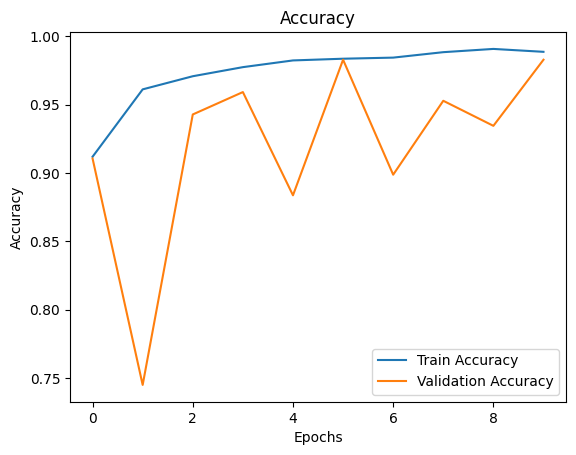

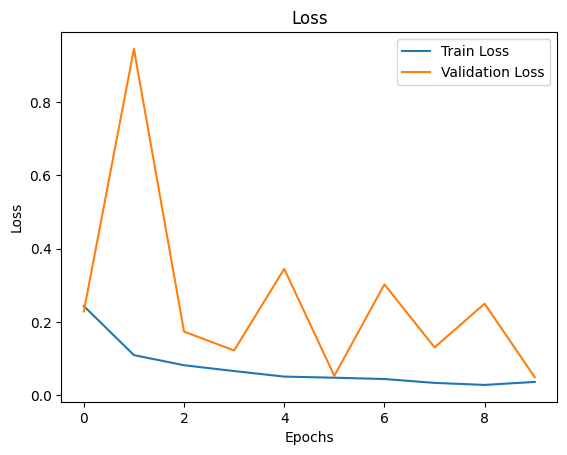

In [6]:
import matplotlib.pyplot as plt

print(history.history.keys())

# 학습 및 검증 정확도 그래프
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("1")
plt.show()

# 학습 및 검증 손실 그래프
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("2")
plt.show()

1/1 [==============================] - 0s 30ms/step
Custom font not found. Using default font.


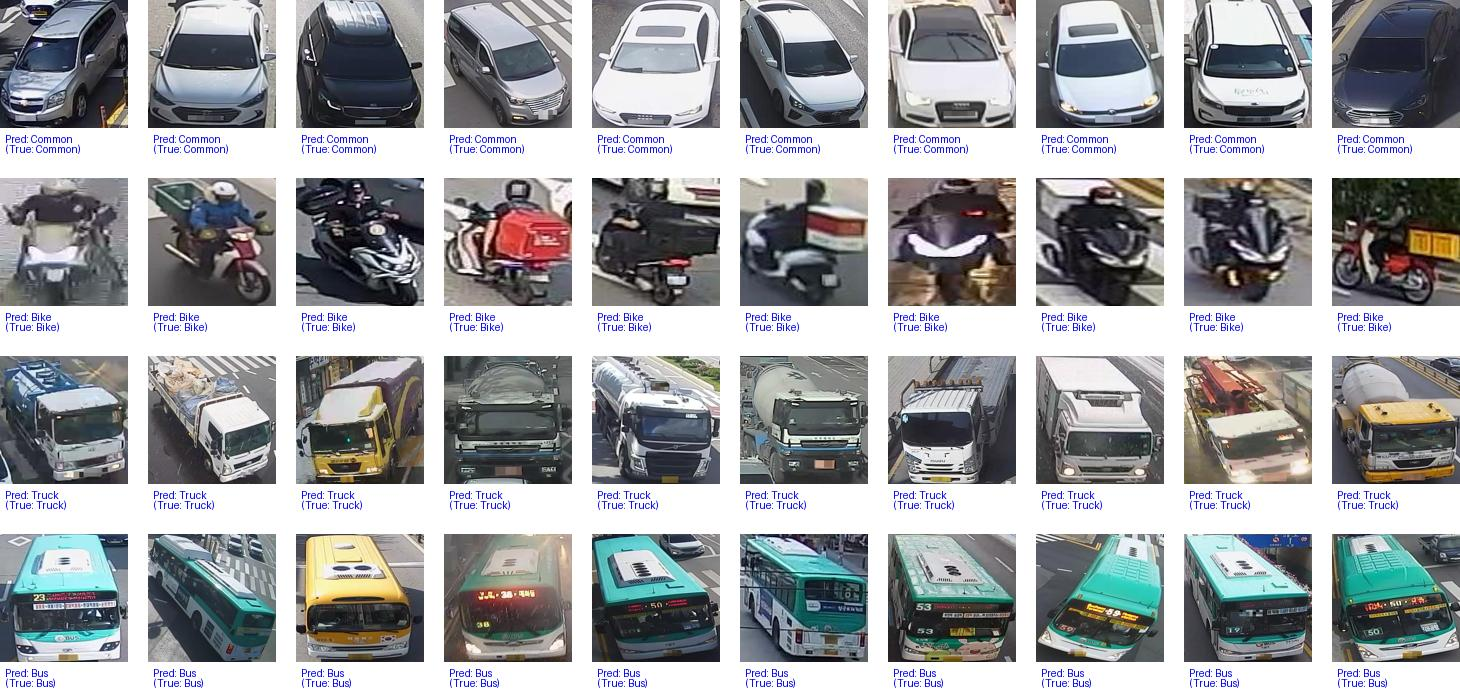

In [5]:
import os
import random
from PIL import Image, ImageDraw, ImageFont
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet import preprocess_input
import numpy as np

# 모델 로드
model = load_model('DenseNet121.h5')

# 데이터 경로와 클래스 설정
test_dir = '../../Dataset_4_class/Test'

index_to_class = [folder for folder in os.listdir(train_dir)
                 if os.path.isdir(os.path.join(train_dir, folder)) and folder != '.ipynb_checkpoints']

# 모델 입력 크기
img_size = (128, 128)  # 모델 입력 크기

# 여백 설정
padding = 20  # 이미지 간 여백 (픽셀 단위)
text_height = 30  # 텍스트 영역 높이

# 랜덤 샘플 테스트
results = []
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    if not os.path.isdir(class_path):  # 디렉토리인지 확인
        continue
    
    # 해당 클래스 폴더의 모든 파일 가져오기
    images = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
    
    # 랜덤으로 10개 선택 (이미지가 10개 미만이면 모두 선택)
    sampled_images = random.sample(images, min(10, len(images)))
    
    # 예측 수행
    for image_path in sampled_images:
        # 이미지 로드 및 전처리
        img = load_img(image_path, target_size=img_size, color_mode='rgb')
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # 예측
        predictions = model.predict(img_array)
        predicted_index = np.argmax(predictions, axis=1)[0]
        predicted_class = index_to_class[predicted_index]

        # 결과 저장
        results.append({
            'image': image_path,
            'predicted_class': predicted_class,
            'true_class': class_name
        })

# 이미지 합치기
num_images_per_row = 10  # 가로에 표시할 이미지 수
output_width = img_size[0] * num_images_per_row + padding * (num_images_per_row - 1)  # 가로 크기
num_rows = (len(results) + num_images_per_row - 1) // num_images_per_row  # 전체 행 수
output_height = (img_size[1] + text_height) * num_rows + padding * (num_rows - 1)  # 세로 크기
output_image = Image.new("RGB", (output_width, output_height), "white")

# 폰트 설정 (기본 폰트 사용)
try:
    font_path = "C:/Windows/Fonts/arial.ttf"  # Windows 시스템 기본 폰트 경로
    font = ImageFont.truetype(font_path, size=12)
except OSError:
    print("Custom font not found. Using default font.")
    font = ImageFont.load_default()

draw = ImageDraw.Draw(output_image)

# 각 이미지를 합친다
x_offset, y_offset = 0, 0
for i, result in enumerate(results):
    # 이미지 열기
    img = Image.open(result['image']).resize(img_size)
    output_image.paste(img, (x_offset, y_offset))
    
    # 예측 텍스트 추가 (이미지 아래, 개행 포함)
    text = f"Pred: {result['predicted_class']}\n(True: {result['true_class']})"
    text_color = "blue" if result['predicted_class'] == result['true_class'] else "red"  # 색상 결정
    
    # 여러 줄 텍스트 작성
    text_x = x_offset + 5
    text_y = y_offset + img_size[1] + 5  # 이미지 바로 아래
    for line in text.split("\n"):  # 개행 기준으로 나누어 작성
        draw.text((text_x, text_y), line, fill=text_color, font=font)
        text_y += 10  # 줄 간격 추가 (폰트 크기 고려)

    # 다음 위치로 이동
    x_offset += img_size[0] + padding
    if x_offset >= output_width:  # 한 줄이 가득 찼을 경우
        x_offset = 0
        y_offset += img_size[1] + text_height + padding

output_image_path = "DenseNet_combined_predictions_colored_text.jpg"
output_image.save(output_image_path)
output_image = Image.open(output_image_path)
display(output_image)